# Final Project for INFO 6350
### Project Team: Yun Zhou (yz2685)

# Part 0: Background

**Statement of the problem:** A 10-K report is a comprehensive report filed annually by a publicly traded company to the U.S. Securities and Exchange Commission (SEC) regarding the company's financial performance and business operations of the last fiscal year. Almost every 10-K report includes content like business overview, industry overview, risk factors, competition, financial statements, income statements, and so on. In the past few years, those reports have been getting more and more in terms of page numbers and word counts. For example, General Electric's (ticker: GE) recent annual report was over 300 pages, American International Group 's (AIG) recent 10-K filing was above 400 pages long. As a result, fewer and fewer independent investors would have the time and patience to read them across all the publicly traded companies. 

**Impact of this project:** The results from my analysis will deliver meaningful recommendations to not only the NLP scholars, but also to the real-world managers,  executives, and investors. By using text mining techniques, we can greatly improve the efficiency of the decision-making process in the business world, saving executives/managers' time reading their competitors' verbose 10K reports. Additionally, the project result will help the individual investors save time analyzing the 10K reports and make better investment decisions in the stock market.   

# Part 1: Research Questions

### Q1: What are the tones or sentiments used to describe the risks of companies? Are they related to the stock prices?

* I will use sentiment analysis and t-test in Q1 with the goal of finding the flunctuation of emotions regarding companies' performances in the stock market in the past 15 years. 

### Q2. Can we build a classifier to categorize the IT sector and non-IT sector by their Risk Factors? If so, what features are most important? 

* The IT companies made up 50% of the entire dataset. Finding a classifier to identify IT vs. non-IT by analzying their risk corpus can be useful when an investor was given an anonymous risk corpus and needs to quickly determine which industry it belongs to. The top features found from the feature matrix can be used as key words to distinguish IT and Non-IT sectors. 

### Q3: Can we build a classifier to categorize the below-average-stock-price and above-average-stock-price by their Risk Factors from 10-K reports? What are the most important features to distinguish them? Can we improve the accuracy of our classifiers? 

* In Q3, I will train and test multiple classifiers to categorize the the end-of-year stock prices of the NASDAQ-100 companies based on the **Risk Factors** section in their 10-K reports in the past 15 years. As an individual investor in the stock market, I found this question the most useful and interesting research question to explore, and possibly help smaller investors make their invest decisions quicker without reading the lengthy 10-K reports by themselves. 

# Part 2: Methodologies

**Web Scraping and Data Collection**

*Scrap the SEC website for 10-K reports*
* Imported the NASDAQ-100 company list with their tickers (symbols), CIKs (Central Index Key), sectors and so on

* Scraped the SEC website based on company CIK to obtain the 10-K reports in the past 15 years (`getDataByCIK()` function):
        
    1. scraped the SEC Query Page and input parameters of interest based on CIK, fiscal years, etc., and get `list_10k` which stores the list of companies’ links to all of their 10-K web pages
    
    2. enumerated `list_10k` to get the company web pages that had individual 10-K report links (note: those web pages contained links to tables and figures in 10-K reports, so I need to go deeper), and stored the links in *list_of_links*
    
    3. enumerated `list_of_links` to scrape every 10-K web page, and stored the link to the actual 10-K text in *list_of_10ks*
    
    4. enumerated `list_of_10ks` to scrape and parse the HTML using `scrap10k()` function


* Parsed every report to collect the text from *Risk Factor* sections

* Created a combined data frame called `df` with metadata and the text data

*Scrap Yahoo Finance website for historical stock prices*
* Scraped Yahoo Finance website based on company ticker (symbol) used in stock market 
* Found the historical stock price data in JSON object and stored them in `HistoricalPriceStore`: 
`HistoricalPriceStore = json_data['context']['dispatcher']['stores']['HistoricalPriceStore']`
* Obtained the stock price in December of the given fiscal year based on the metadata in the data frame `df_fi`
* Combined the stock price data frame `df_fi`with the data frame `df` above 

**Data Cleaning and Exploratory Analysis:**

* Excluded any invalid stock prices 
* Cleaned the corpus by replacing “\”, “\ in\ form”, “\n”, and made all words lowercase
* Appended the cleaned corpus to the `df` 
* Created tables and charts to get high-level ideas of the statistics of the data
* Performed basic descriptive analysis to find the possible features that might affect the stock price
* Excluded the records with stock price above USD 250, since only several companies reached that high and would skew the data
* Removed duplicates based on CIK and fiscal year in the `df`
* Generated word cloud for the corpus 
* Saved the data frame in a local file called *data.csv* (I chose to load the data into a new data frame for the sake of testing, since the web scraping part took about an hour to finish)

**Q1: What are the tones or sentiments used to describe the risks of companies? Are they related to the stock prices?**

The purpose of our first research question is to explore basic features of the risk factor corpus, trying to find what features can be used in our classification tasks in the following research questions. 

The first exploration is sentiment analysis grouped by the below-average-stock-price vs. above-average-stock-price. To do so, I did the following:
* created a list of stopwords along with punctuation marks
* loaded emolex lexicon file as a dictionary of sentiments
* tokenized the text while excluding the stopwords list
* calculated the mean sentiment scores for each risk factor text
* performed a t-test and calculated the t-statistic and p-value 
* calculated and visualized the mean sentiment scores by `y_binary` 
* did the same thing for the sentiment analysis by sector 

Next, I conducted clustering to find distinct groups or clusters within the risk corpus.
* created a vectorizer using `TfidfVectorizer` based on the entire risk corpus
* built K Means clustering with number of clusters = 7, since there are 7 sectors in our dataset
* referred the `plot_compare` and `pull_samples` functions from lecture
* visualized the clusters and pulled 3 samples from each of the clusters 
* evaluate the samples and results from the clusters 

Then, I created descriptive analysis on the mean and frequencies for word_count and stock prices grouped by the sector attribute. 

**Q2: Can we build a classifier to categorize the below-average-stock-price and above-average-stock-price by their Risk Factors from 10-K reports? What are the most important features to distinguish them? Can we improve the accuracy of our classifiers?** 

The purpose of this research question is to explore possible features that differentiate the sectors. Since IT companies consisted of about 55% of the population, I decided to create a classifier for the IT vs. non-IT sector based on the risk corpus. 
* got the statistics for the`word_count` and `price` by sector 
* referred the `compare_scores` function from lecture to compare the classification results 
* created a gold label, `y_it`, to separate the records into IT and non-IT sectors 
* calculated baseline_accuracy, baseline_f1 for `y_it`
* selected the 20 most important features from `X` for `y_it`
* trained and tested multiple classifiers for `X` and `y_it` 
* cross-validated the results using 10 folds and compared their metrics 
* optimized the parameters the RandomForest classifier and improve the metric

**Q3: Can we build a classifier to categorize the below-average-stock-price and above-average-stock-price by their Risk Factors from 10-K reports? What are the most important features to distinguish them? Can we improve the accuracy of our classifiers?**

**Token-based Feature Matrix**

First, I built a token-based feature matrix and fit it into various classifiers. 
* selected 50 most important features from the token-based feature matrix, `X`, from the previous problem
* trained and tested multiple classifiers for `X` and `y_binary` 
* cross-validated the results using 10 folds and compared their metrics 

Next, I tried several methods to improve the accuracy score of the classifiers. 

*feature engineering*

* expanded the list of features from 50 to 100 into a new feature matrix, `X_token_k`
* trained and tested multiple classifiers for `X_token_k` and `y_binary` 
* cross-validated the results using 10 folds and compared their metrics 

*optimized parameters of classifier*

* changed the `max_depth` of the decision tree classifiers and compared the metrics 
* changed the max features of the random forest classifiers and compared the metrics 
* trained and tested the updated classifiers for `X_token_k` and `y_binary` 
* cross-validated the results using 10 folds and compared their metrics 

**Embedding-based Feature Matrix**

Then, I built an embedding-based feature matrix and fit it into various classifiers. 
* created a `get_doc_embedding` function that takes as arguments a text string and a spaCy NLP factory object and returns a word embedding vector, excluding stopwords, punctuations, and spaces 
* created an embedding-based feature matrix, `X_embedding`, with a numpy array of shape `len(data)` x `nlp.vocab.vectors_length`
* standard scaled the embedding feature matrix and computed a 10-fold cross-validated logistic regression classification score
* trained and tested the updated classifiers for `X_token_k` and `y_binary` 
* cross-validated the results using 10 folds and compared their metrics 

**Entities & POS Tag Feature Matrix**

* used spaCy to count the number of entities and the number of tokens tagged with parts of speech of the types: `'PERSON', 'MONEY', 'TIME', 'ADJ', 'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'PRON', 'PROPN', 'VERB'`. 
* generated a feature matrix that has 12 total features, one for each of the indicated entity or POS types
    * stored the counts for each risk corpus in a dictionary
    * store all of your counters in a list
* sum of the counts for the entities and POS tags across the whole corpus
* visualize the counts 
* used a `DictVectorizer` to transform the list of populated counters into a feature matrix `X_trans`
* standard scaled the resulting matrix
* trained and tested the updated classifiers for `X_trans` and `y_binary` 
* cross-validated the results using 10 folds and compared their metrics 
* cross-validated the random forest classifier with different parameters and calculated the metrics 

**Topic Modeling Feature Matrix**

* created a `CountVectorizer`, excluding stopwords, numbers, etc., called `X_topic`
* standard scaled the resulting matrix
* created an `LDA` object to select the most weighted words within the top 20 topics
* referred the `print_top_words` function lecture code and prints the top words per topic 
* created a doc-topic feature matrix called `doc_topic_matrix` based on `X_topic`
* trained and tested multiple classifiers for `doc_topic_matrix` and `y_binary` 
* cross-validated the results using 10 folds and compared their metrics 


# Part 3: Code

In [61]:
import requests
import urllib
from bs4 import BeautifulSoup
import simplejson as json
from urllib.request import Request, urlopen
from fake_useragent import UserAgent
from selenium import webdriver
import time
import re
import pandas as pd
import json
import datetime
import numpy as np
import unicodedata
from collections import Counter
from nltk import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt
import pickle
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.feature_selection import SelectKBest, mutual_info_classif
from   sklearn.linear_model import LogisticRegression, LinearRegression
from   sklearn.model_selection import cross_val_score
from   sklearn.preprocessing import StandardScaler
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from   sklearn.cluster import KMeans, SpectralClustering, DBSCAN, OPTICS, AgglomerativeClustering
import os
import string
import copy
from   collections import defaultdict
from   nltk.corpus import stopwords
from   sklearn.feature_selection import SelectKBest, mutual_info_regression
from wordcloud import WordCloud 
import seaborn as sns
from   sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_validate
import pyLDAvis
import pyLDAvis.sklearn
import warnings
import pyLDAvis.gensim_models as gensimvis
from   sklearn.decomposition import LatentDirichletAllocation
from   sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import ttest_ind
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.svm import LinearSVC

## I: Web Scraping

### Please refer to `web-scraping-and-data-prep.ipynb` for I: Web Scraping

## II: Data Cleaning & Exploratory Analysis

### Please refer to `web-scraping-and-data-prep.ipynb` for II: Data Cleaning & Exploratory Analysis

## III: Text Analysis

#### Load the scraped and cleaned data from `data.csv` into a data frame `df`

In [2]:
df = pd.read_csv('data.csv').fillna(value = 0)

## Q1: What are the tones or sentiments used to describe the risks of companies? Are they related to the stock prices?

### 0. Create gold labels

* Create a vector **y_binary** of gold labels for stock prices. 0 stands for below-average stock prices and 1 represents above-average stock prices. 

In [3]:
y_binary = list(map(lambda x : 0 if x < np.mean(df.price) else 1, df.price))

In [4]:
len(y_binary)

304

In [5]:
baseline_accuracy = np.sum(y_binary) / len(y_binary)
baseline_precision = baseline_accuracy
baseline_recall = 1.0
baseline_f1 = 2*baseline_precision*baseline_recall/(baseline_precision+baseline_recall)
print("Baseline accuracy:", round(baseline_accuracy, 3))
print("Baseline F1:", round(baseline_f1, 3))

Baseline accuracy: 0.395
Baseline F1: 0.566


#### It seemed about 39.47% of the stock prices were above the average, which indicated that there are some high outliers (a few top performaners which had high stock prcies), which might skew the df. 

### 1. Sentiment Analysis

In [6]:
# Making stopwords list
stoplist = stopwords.words('english')
for el in [i for i in string.punctuation]:
    stoplist.append(el)

In [7]:
emolex_file = os.path.join('emolex.txt')

In [8]:
# read_emolex function from INFO 3350 problem set code

emolex_file = os.path.join('emolex.txt')

def read_emolex(filepath=None):
    '''
    Takes a file path to the emolex lexicon file.
    Returns a dictionary of emolex sentiment values.
    '''
    if filepath==None: # Try to find the emolex file
        filepath = os.path.join('emolex.txt')
        if os.path.isfile(filepath):
            pass
        elif os.path.isfile('emolex.txt'):
            filepath = 'emolex.txt'
        else:
            raise FileNotFoundError('No EmoLex file found')
    emolex = defaultdict(dict) # Like Counter(), defaultdict eases dictionary creation
    with open(filepath, 'r') as f:
    # emolex file format is: word emotion value
        for line in f:
            word, emotion, value = line.strip().split()
            emolex[word][emotion] = int(value)
    return emolex

# Get EmoLex data. Make sure you set the right file path above.
emolex = read_emolex(emolex_file)

In [9]:
# Get EmoLex df. Make sure you set the right file path above.
emolex = read_emolex(emolex_file)

In [10]:
def getSentScore(sentence_dicts, df, index):
    
    bookdict = dict({'anger': 0 , 'anticipation': 0,'disgust': 0,'fear': 0,'joy': 0,'negative': 0,'positive': 0,'sadness': 0,'surprise': 0, 'trust': 0})
    
    for sentence_dict in sentence_dicts:
        for emotion in sentence_dict:
            bookdict[emotion] += sentence_dict[emotion]
    
    for emotion in bookdict.keys():
        bookdict[emotion] /= len(sentence_dicts)
        df.at[index, emotion] = bookdict[emotion]
    
    return None  

In [11]:
def tokenize_text(text, stops=[]):
    sentences = []
    for sent in sent_tokenize(text.lower()):
        sentences.append([word for word in word_tokenize(sent) if word not in stops])
        
    return sentences

In [12]:
# sentence_sentiment_score from INFO 3350 problem set code
def sentence_sentiment_score(toks, lexicon = emolex):
    total = 0
    emo_dict = defaultdict(lambda: 0)
    
    emotions = ['anger', 'anticipation','disgust','fear','joy','negative','positive','sadness','surprise', 'trust']
    
    
    for word in toks:
        total += 1
        for emotion in emotions:
            try:
                emo_dict[emotion] += lexicon[word][emotion]
            except:
                continue
    
    for emotion in emotions:
        if total > 0:
            emo_dict[emotion] /= total
        
    return emo_dict

In [13]:
#### Adding sentiment score columns
size = len(df)

df['anger'] = np.zeros(size)
df['anticipation'] = np.zeros(size)
df['disgust'] = np.zeros(size)
df['fear'] = np.zeros(size)
df['joy'] = np.zeros(size)
df['negative'] = np.zeros(size)
df['positive'] = np.zeros(size)
df['sadness'] = np.zeros(size)
df['surprise'] = np.zeros(size)
df['trust'] = np.zeros(size)

In [14]:
len(df)

304

In [15]:
%%time

for index, text in enumerate(df['risk']):
    sentence_dicts = []
    for sentence in tokenize_text(text, stops=stoplist):
        sentence_dicts.append(sentence_sentiment_score(sentence))
    getSentScore(sentence_dicts, df, index)

CPU times: user 1min 2s, sys: 525 ms, total: 1min 3s
Wall time: 1min 6s


In [16]:
df.tail()

,Unnamed: 0,cik,symbol,company,fiscal_year,risk,sector,url,price,text,...,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
299,320,900075,CPRT,"Copart, Inc. (DE) Common Stock",2016,item 1a. risk factorsinvesting in our commo...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,27.705000,item 1a. risk factorsinvesting in our commo...,...,0.019701,0.038329,0.016762,0.030321,0.009661,0.066185,0.094219,0.023611,0.008625,0.052095
300,321,900075,CPRT,"Copart, Inc. (DE) Common Stock",2014,item 1a.\n \nrisk factors\n\n\n\ninvesting in ...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,18.245001,item 1a. risk factors investing in our co...,...,0.023981,0.037899,0.019341,0.033534,0.010873,0.066368,0.096863,0.026728,0.007782,0.053089
301,322,900075,CPRT,"Copart, Inc. (DE) Common Stock",2013,item 1a.\n \nrisk factors\n\n\n\ninvesting in ...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,18.325001,item 1a. risk factors investing in our co...,...,0.024179,0.039362,0.020800,0.036514,0.010880,0.067244,0.098653,0.028181,0.007672,0.053146
302,323,900075,CPRT,"Copart, Inc. (DE) Common Stock",2010,item 1a. risk factors \n investing ...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,9.337500,item 1a. risk factors investing i...,...,0.023554,0.040803,0.019069,0.033254,0.010905,0.065662,0.104372,0.025967,0.006681,0.050782
303,324,900075,CPRT,"Copart, Inc. (DE) Common Stock",2009,item 1a. risk factors \n investi...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,9.155000,item 1a. risk factors investin...,...,0.024608,0.038114,0.019443,0.033097,0.011708,0.066980,0.103876,0.026330,0.005692,0.049739


In [17]:
df.describe()

,Unnamed: 0,cik,fiscal_year,price,word_count,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
count,304.000000,3.040000e+02,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000
mean,160.911184,8.834649e+05,2013.154605,55.872967,20770.375000,0.017637,0.041907,0.009962,0.027525,0.018901,0.059696,0.105277,0.023928,0.009313,0.059365
std,94.628030,3.874983e+05,3.549617,45.485301,17656.526626,0.004749,0.006466,0.003954,0.006934,0.004922,0.011735,0.009175,0.005281,0.003183,0.008030
min,0.000000,2.488000e+03,2007.000000,1.630000,1423.000000,0.007411,0.027373,0.001337,0.011841,0.005467,0.034340,0.081583,0.012612,0.003284,0.039743
25%,77.750000,7.693970e+05,2010.000000,22.351250,8559.500000,0.014453,0.037874,0.007385,0.021839,0.016099,0.050279,0.099411,0.020588,0.007238,0.054046
50%,162.500000,8.911030e+05,2013.000000,43.465000,13549.000000,0.017320,0.042030,0.009856,0.028327,0.018006,0.060357,0.105674,0.023531,0.008982,0.058147
75%,240.250000,1.094455e+06,2016.000000,74.807501,27734.750000,0.020033,0.044576,0.012538,0.032216,0.020773,0.067393,0.111322,0.027425,0.010611,0.063793
max,324.000000,1.811210e+06,2020.000000,231.669998,80342.000000,0.041867,0.069143,0.027367,0.050213,0.037843,0.093268,0.130600,0.042139,0.021311,0.086329


#### Visualize the sentiment analysis

In [18]:
# from INFO 3350 problem set
def visualize_emotion_scores(scores, cols, xLabel):
    df = pd.DataFrame.from_dict(scores)
    values = df.columns
    df = df.reset_index().melt(id_vars='index', value_vars=values, var_name='emotion').rename(columns={'index':xLabel})
    sns.set_context('poster')
    g = sns.catplot(x=xLabel, y='value', col='emotion', data=df, kind='bar', col_wrap=cols)
    g.set_xticklabels(rotation = 90, fontsize=10)
    return g

In [19]:
grouped_sent = df.groupby(y_binary).mean()\
[['anger','anticipation','disgust','fear','joy','negative','positive','sadness','surprise', 'trust']]

print("Average detective novel sentiment scores in comparison to average sentiment scores of all other genres in \
the corpus. \n\
'True' indicates detective novels.")

grouped_sent

Average detective novel sentiment scores in comparison to average sentiment scores of all other genres in the corpus. 
'True' indicates detective novels.


,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,0.017662,0.041922,0.010006,0.027683,0.018833,0.059660,0.104365,0.02416,0.009218,0.058108
1,0.017599,0.041885,0.009894,0.027282,0.019003,0.059752,0.106675,0.02357,0.009458,0.061293


In [20]:
sent_dict = grouped_sent.to_dict()

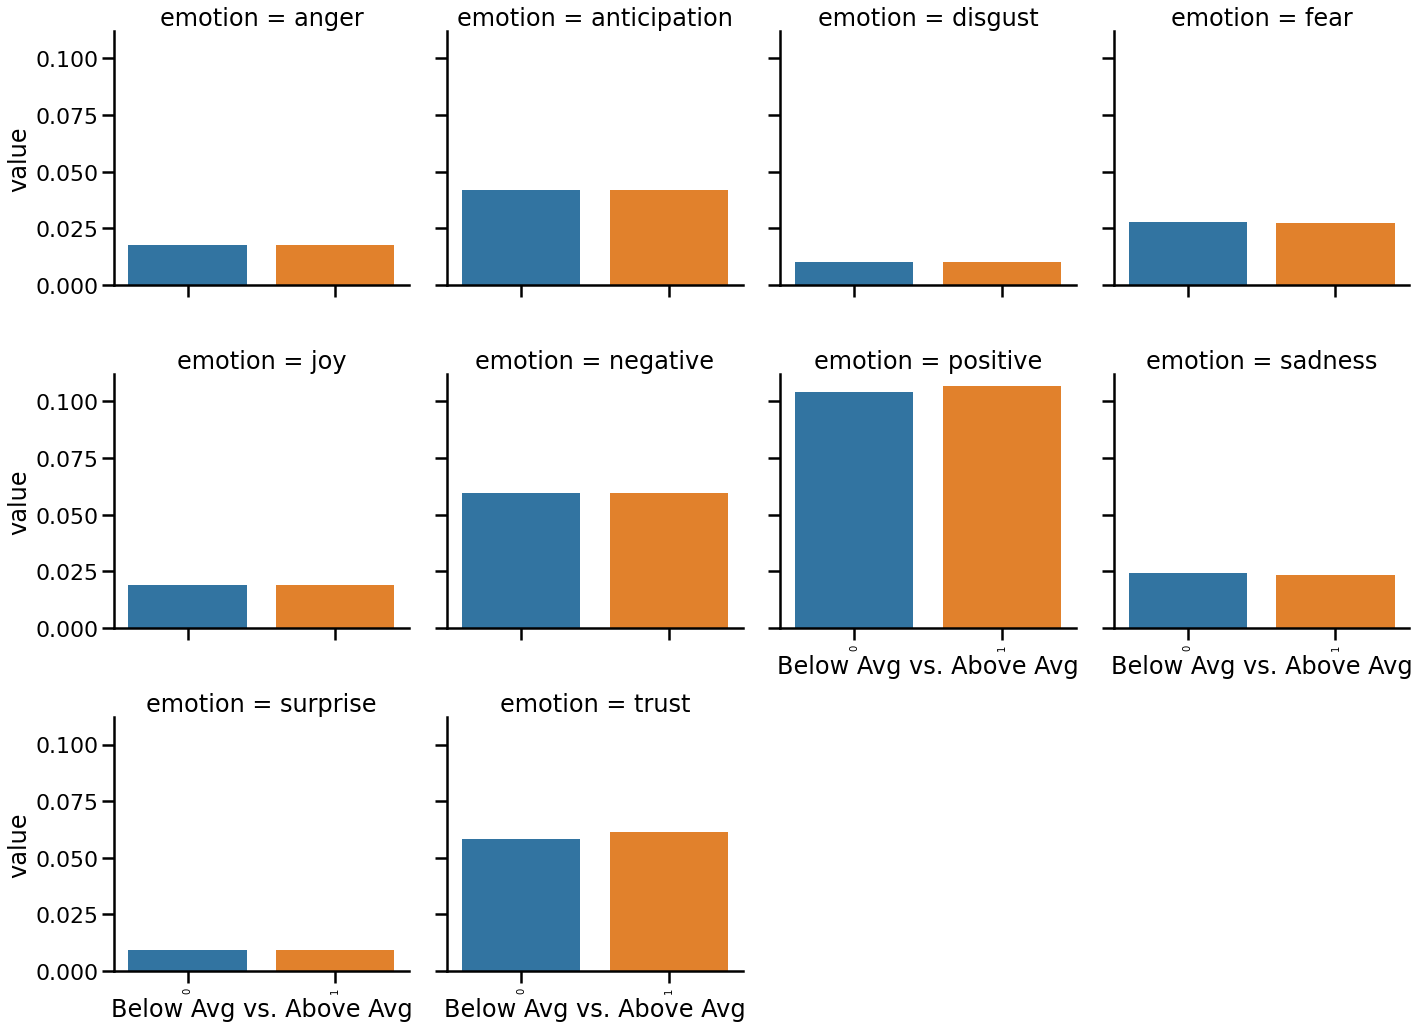

In [21]:
visualize_emotion_scores(sent_dict, 4, 'Below Avg vs. Above Avg')

In [22]:
emotions = ['anger', 'anticipation','disgust','fear','joy','negative','positive','sadness','surprise', 'trust']

for emo in emotions:
    stat, p = ttest_ind(
        df.loc[df.price < np.mean(df.price)][emo], 
        df.loc[df.price >= np.mean(df.price)][emo],
        equal_var=False
    )
    print(f"{emo}")
    print('t-statistic:\t', round(stat, 5))
    print('p-value:    \t', round(p, 5), '\n')

anger
t-statistic:	 0.11521
p-value:    	 0.90836 

anticipation
t-statistic:	 0.04748
p-value:    	 0.96218 

disgust
t-statistic:	 0.24921
p-value:    	 0.80338 

fear
t-statistic:	 0.50331
p-value:    	 0.61516 

joy
t-statistic:	 -0.28429
p-value:    	 0.77645 

negative
t-statistic:	 -0.06636
p-value:    	 0.94714 

positive
t-statistic:	 -2.10956
p-value:    	 0.03596 

sadness
t-statistic:	 0.95954
p-value:    	 0.33817 

surprise
t-statistic:	 -0.64227
p-value:    	 0.52127 

trust
t-statistic:	 -3.37808
p-value:    	 0.00085 



* Acorss all the emotions, it seemed those publicly traded companies tended to use **positive** tones in their writings of the Risk Factors section no matter what their stock performances were, compared to any other emotions. 

* The emotion **surprise** is the least mentioned in the Risk Factors section. It seemed those companies used caution when publishing their 10-K annual reports, trying not to deliver any surprising messages to scare them away. 

* Both the **positive** and **trust** emotions showed statistically significant (p-value < 0.05) between below-average and above-average stock prices. Namely, when companies perfomed better than the average stock prices, they tended to be more optimistic about thier risks and would assure their investors about their competence. 

#### Sentiment analysis by sector

In [23]:
sent_sector = df.groupby(df.sector).mean()\
[['anger','anticipation','disgust','fear','joy','negative','positive','sadness','surprise', 'trust']]

print("Average detective novel sentiment scores in comparison to average sentiment scores of all other genres in \
the corpus. \n\
'True' indicates detective novels.")

sent_sector

Average detective novel sentiment scores in comparison to average sentiment scores of all other genres in the corpus. 
'True' indicates detective novels.


,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
sector,,,,,,,,,,
Communication Services,0.017907,0.046434,0.010235,0.025370,0.023546,0.057030,0.103963,0.024235,0.012803,0.061518
Consumer Discretionary,0.020141,0.046028,0.011358,0.028109,0.023078,0.061278,0.108391,0.025355,0.012028,0.063059
Consumer Staples,0.017539,0.040549,0.011603,0.027445,0.019326,0.063433,0.108508,0.026673,0.008911,0.055298
Health Care,0.014626,0.040880,0.009368,0.029830,0.016184,0.058529,0.105661,0.021307,0.008196,0.056657
Industrials,0.018230,0.040832,0.010050,0.029187,0.016170,0.060518,0.104939,0.024201,0.006625,0.058790
Information Technology,0.018013,0.040952,0.009614,0.026815,0.018270,0.060279,0.104971,0.024352,0.008752,0.060054
Utilities,0.012886,0.030101,0.007581,0.026168,0.015492,0.046936,0.091092,0.015416,0.009377,0.044091


In [24]:
sent_sec_dict = sent_sector.to_dict()

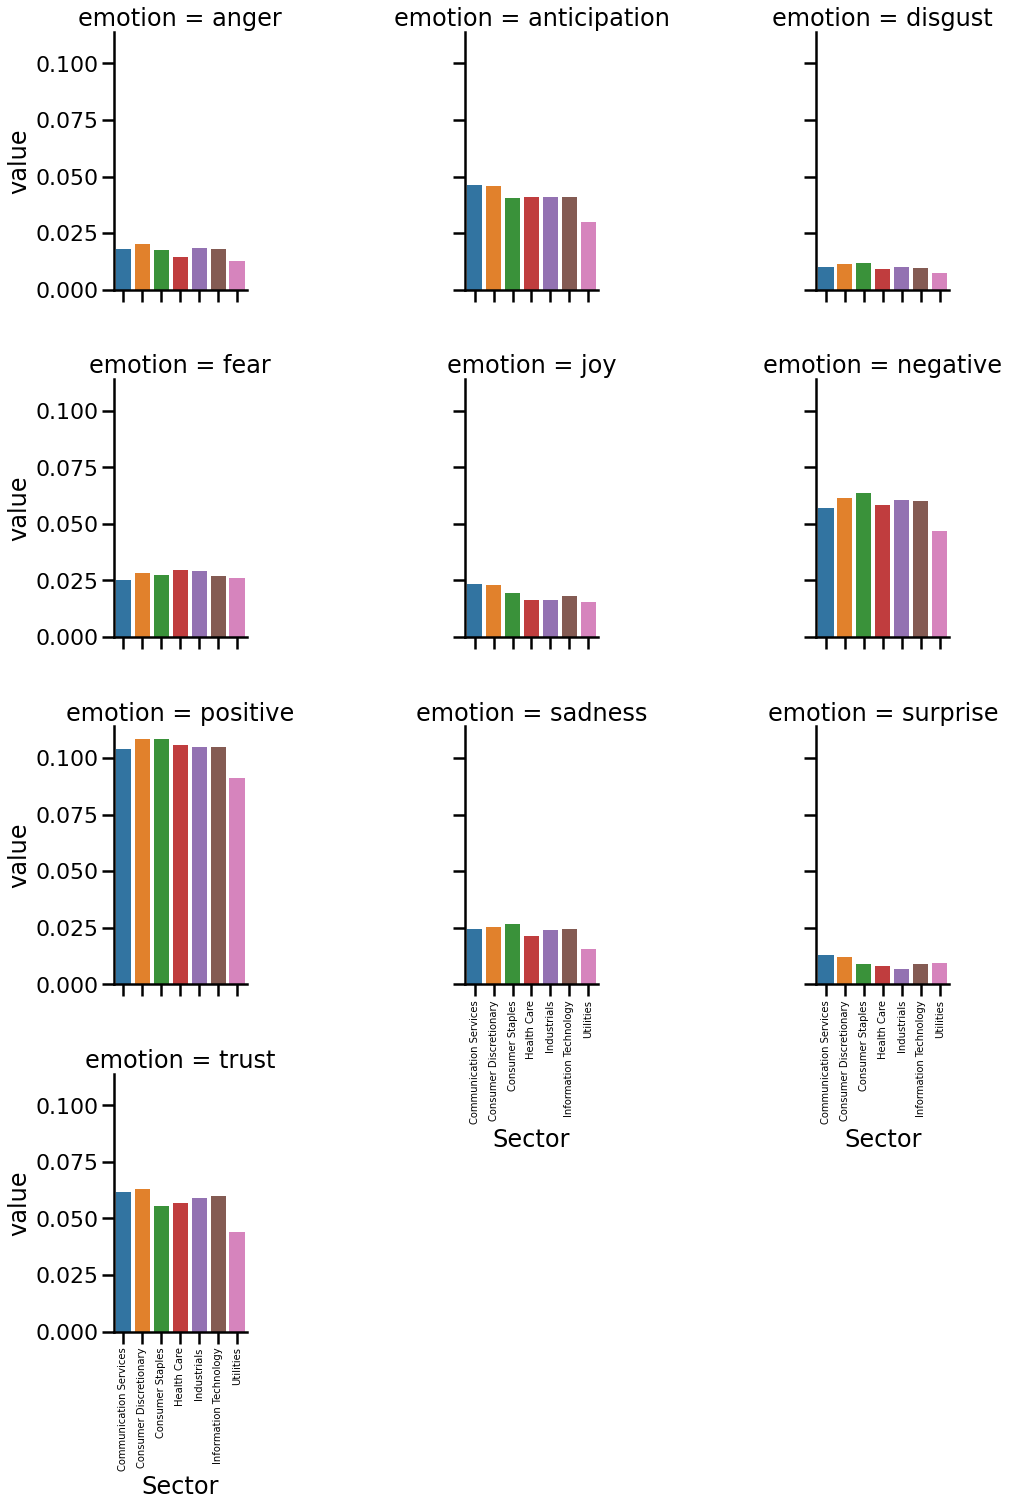

In [25]:
visualize_emotion_scores(sent_sec_dict, 3, 'Sector')

#### Looking at the mean sentiment scores by sector, we could get some interesting findings. 

In [26]:
df[df['sector'] == 'Utilities'].company.unique()

array(['Exelon Corporation Common Stock'], dtype=object)

(1) The sector **Utilities** appeared to have the lowest mean sentiment scores among any other sectors, except for the *surprise* emotion. In our dataset, there is only one company made up this category: 'Exelon Corporation'. So, the sentiment result might be underrepresented. 

In [27]:
df[df['sector'] == 'Consumer Discretionary'].company.unique()

array(['Lucid Group, Inc. Common Stock', 'Amazon.com, Inc. Common Stock',
       "O'Reilly Automotive, Inc. Common Stock",
       'MercadoLibre, Inc. Common Stock',
       'lululemon athletica inc. Common Stock',
       'Dollar Tree Inc. Common Stock', 'Ross Stores, Inc. Common Stock',
       'Booking Holdings Inc. Common Stock',
       'Airbnb, Inc. Class A Common Stock',
       'Marriott International Class A Common Stock',
       'Tesla, Inc. Common Stock'], dtype=object)

(2) The **Consumer Discretionary** sector would like to deliver *anticipation*, *positivity* and *trust* emotions to their audience in their Risk Factors sections. Companies in this sector included Tesla, Airbnb, Amazon, Lululemon, Dollar Tree, and so on. In common sense, most of them were also considered fast-growing companies in the past 15 years. 

In [28]:
df[df['sector'] == 'Consumer Staples'].company.unique()

array(['Walgreens Boots Alliance, Inc. Common Stock',
       'PepsiCo, Inc. Common Stock',
       'Mondelez International, Inc. Class A Common Stock',
       'The Kraft Heinz Company Common Stock'], dtype=object)

(3) The **Consumer Staples** sector showed slightly more worries regarding the risks in their 10-K reports and ranked the highest in *sadness* and *negative* emotion categories. There are four companies in this category in our dataset: Walgreens, PepsiCo, Mondelez International, and The Kraft Heinz Company. This industry was regarded as steady, less risky and volatile, which might be the reason why companies might not pay attention to the *sadness* or *negativeness* in their statements. 

#### 1-2-0 Create Vectorizer

In [29]:
# Vectorize
vectorizer = TfidfVectorizer(
    encoding = 'utf-8',
    strip_accents = 'unicode',
    lowercase = True,
    min_df = 0.01,
    max_df = 0.9,
    use_idf=True,
    token_pattern=r'(?u)\b[A-Za-z]+\b'
)

In [30]:
# perform vectorization
X = vectorizer.fit_transform(df.risk.values.astype('U'))
print("Shape of the feature matrix", X.shape)

Shape of the feature matrix (304, 11309)


In [31]:
# standard-scale feature matrix
X = StandardScaler().fit_transform(X.todense())

/Users/annzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/annzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


### 2. Clustering

In [32]:
############## code from INFO 6350 problem set code ##############
def plot_compare(X, labels, title, reduce=True, alpha=0.2):
    '''
    Takes an array of object data, a set of cluster labels, and a title string
    Reduces dimensions to 2 and plots the clustering.
    Returns nothing.
    '''
    
    if reduce:
        # TruncatedSVD is fast and can handle sparse inputs
        # PCA requires dense inputs; MDS is slow
        coordinates = TruncatedSVD(n_components=2).fit_transform(X)
    else:
        # Optionally handle 2-D inputs
        coordinates = X
    
    # Set up figure
    fig, ax = plt.subplots(figsize=(12,6))

    # Unlabeled data
    plt.subplot(121) # 1x2 plot, position 1
    plt.scatter(
        coordinates[:, 0], 
        coordinates[:, 1], 
        alpha=alpha, # Set transparency so that we can see overlapping points
        linewidths=0 # Get rid of marker outlines
    )
    plt.title("Unclustered data")

    # Labeled data
    plt.subplot(122)
    sns.scatterplot(
        x=coordinates[:, 0], 
        y=coordinates[:, 1],
        hue=labels,
        alpha=alpha,
        palette='viridis',
        linewidth=0
    )
    plt.title(title)
    plt.show()

In [33]:
############## code from INFO 6350 problem set code ##############
def pull_samples(texts, labels, n=3):
    '''
    Takes lists of texts and an array of labels, as well as number of samples to return per label.
    Prints sample texts belonging to each label.
    '''
    texts_array = np.array(texts) # Make the input text list easily addressable by NumPy
    for label in np.unique(labels): # Iterate over labels
        print("Label:", label)
        sample_index = np.where(labels == label)[0] # Limit selection to current label
        print("Number of texts in this cluster:", len(sample_index), '\n')
        chosen = np.random.choice(sample_index, size=n) # Sample n texts with this label
        for choice in chosen:
            print("Sample text:", choice)
            # print(str(texts_array[choice]).split(" 0")[0], '\n') # Print each sampled text
            print(str(texts_array[choice])[1:80]) # Print each sampled text
            print("fiscal year: ", texts.fiscal_year[choice])
            print("company: ", texts.company[choice])
            print("word count: ", texts.word_count[choice])
            print("sector: ", texts.sector[choice])
            print(texts.url[choice], '\n')
        print("###################################")

Label vector shape:  (304,)
Using KMeans clustering with n=7 clusters; we are assuming that the clusters are based on sectors.


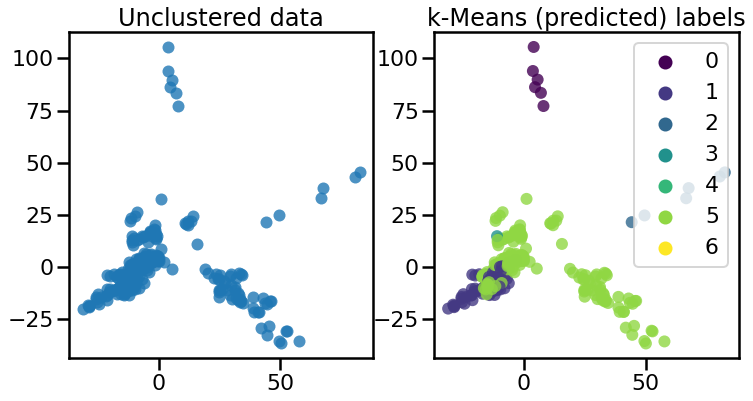

In [34]:
y_kmeans = KMeans(n_clusters=7).fit_predict(X) # this output is the cluster labels

# Print label vector shape
print('Label vector shape: ', y_kmeans.shape)

print("Using KMeans clustering with n=7 clusters; we are assuming that the clusters are based on sectors.")

# Plot results
plot_compare(X, y_kmeans, 'k-Means (predicted) labels', reduce=True, alpha=0.8)

In [35]:
pull_samples(df, y_kmeans, 3)

Label: 0
Number of texts in this cluster: 6 

Sample text: 144
152 318154 'AMGN' 'Amgen Inc. Common Stock' 2010
 'item 1a. risk factors — our 
fiscal year:  2010
company:  Amgen Inc. Common Stock
word count:  30629
sector:  Health Care
https://www.sec.gov/Archives/edgar/data/318154/000095012311018800/v57113e10vk.htm 

Sample text: 141
149 318154 'AMGN' 'Amgen Inc. Common Stock' 2015
 'item 1a. risk factors—our pr
fiscal year:  2015
company:  Amgen Inc. Common Stock
word count:  21056
sector:  Health Care
https://www.sec.gov/Archives/edgar/data/318154/000031815416000031/amgn-12312015x10k.htm 

Sample text: 142
150 318154 'AMGN' 'Amgen Inc. Common Stock' 2013
 "item 1a. risk factors — our 
fiscal year:  2013
company:  Amgen Inc. Common Stock
word count:  21114
sector:  Health Care
https://www.sec.gov/Archives/edgar/data/318154/000031815414000004/amgn-12312013x10k.htm 

###################################
Label: 1
Number of texts in this cluster: 70 

Sample text: 233
246 1327567 'PANW' '

#### From the samples pulled, companies in all the clusters, except for cluster 1, might have distinct writings in their risk factors, compared to their counterparts, because they appeared multiple times in those clusters. It might be helpful to conduct named entities and exclude the company names to see if the clusters change. The samples pulled did not indicate the clusters were aggregated by sector. 

## Q2. Can we build a classifier to categorize the IT sector and non-IT sector by their Risk Factors? If so, what features are most important? 

In [36]:
df.groupby('sector').agg({'word_count':['mean','count']})

word_count      
                                mean count
sector                                    
Communication Services  17964.441176    34
Consumer Discretionary  20019.166667    36
Consumer Staples        11442.187500    16
Health Care             27873.934783    46
Industrials             22655.129032    31
Information Technology  19247.503704   135
Utilities               36119.166667     6

In [37]:
df.groupby('sector').agg({'price':['mean','count']})

price      
                             mean count
sector                                 
Communication Services  46.934595    34
Consumer Discretionary  79.782885    36
Consumer Staples        63.945626    16
Health Care             64.014348    46
Industrials             50.418908    31
Information Technology  50.322752   135
Utilities               32.179030     6

#### Looking at the statistics, it appeared over 50% of the sectors in the dataset is IT. Utitlies sector has the most average word_count, while Consumer Discretionary sector has the highest mean stock price. 

In [38]:
# Examine the performance of our simple classifiers
# Freebie function to summarize and display classifier scores
def compare_scores(scores_dict):
    '''
    Takes a dictionary of cross_validate scores.
    Returns a color-coded Pandas dataframe that summarizes those scores.
    '''
    import pandas as pd
    df = pd.DataFrame(scores_dict).T.applymap(np.mean).style.background_gradient(cmap='RdYlGn')
    return df

In [39]:
y_it = list(map(lambda x : 0 if x == 'Information Technology' else 1, df['sector']))

In [40]:
# Baseline accuracy and F1
#  What if we just guess 1 every time?
baseline_accuracy_it = np.sum(y_it)/len(y_it)
baseline_precision_it = baseline_accuracy_it
baseline_recall_it = 1.0
baseline_f1_it = 2*baseline_precision_it*baseline_recall_it/(baseline_precision_it+baseline_recall_it)
print("Baseline accuracy for IT vs. Non-IT:", round(baseline_accuracy_it, 3))
print("Baseline F1 for IT vs. Non-IT:", round(baseline_f1, 3))

Baseline accuracy for IT vs. Non-IT: 0.556
Baseline F1 for IT vs. Non-IT: 0.566


In [41]:
selector_k = SelectKBest(score_func=mutual_info_regression, k=20)

# Print the shape of your new feature matrix
X_token_k_it = selector_k.fit_transform(X, y_it)
print("Shape of the matrix with 20 selected features: ", X_token_k_it.shape)

Shape of the matrix with 20 selected features:  (304, 20)


### Try out multiple classifiers with 20 most important features

In [42]:
classifiers = {
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression(),
    'Decision tree':DecisionTreeClassifier(),
    'Random forest':RandomForestClassifier()
}

scores = {}

for classifier in classifiers:
    scores[classifier] = cross_validate(classifiers[classifier], X_token_k_it, y_it, cv=10, scoring=['accuracy', 'recall', 'f1', 'f1_macro', 'f1_micro'])

compare_scores(scores)

,fit_time,score_time,test_accuracy,test_recall,test_f1,test_f1_macro,test_f1_micro
kNN,0.000496,0.004579,0.793118,0.894118,0.833363,0.775509,0.793118
Logit,0.006022,0.003028,0.822151,0.841176,0.827235,0.812900,0.822151
Decision tree,0.001481,0.002894,0.749677,0.781985,0.774239,0.736323,0.749677
Random forest,0.118192,0.011561,0.878387,0.888235,0.889072,0.872576,0.878387


#### Looks like Random Forest classifer has the best accuracy and F1. I will try improve it below.  

### Optimize parameters of classifiers

In [43]:
# trying diff max_features
RFfeatures = {
    'feature_None':RandomForestClassifier(max_features=None),
    'feature_100':RandomForestClassifier(max_features=10),
    'feature_5':RandomForestClassifier(max_features=5),
    'feature_2':RandomForestClassifier(max_features=2),
    'est_og':RandomForestClassifier()
}

RFscores1 = {} 
for classifier in RFfeatures:
    RFscores1[classifier] = cross_validate( 
        RFfeatures[classifier], 
        X_token_k_it, # feature matrix
        y_it, # gold labels
        cv=10, 
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] 
    )

compare_scores(RFscores1)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
feature_None,0.150575,0.011565,0.875484,0.923147,0.858824,0.880739,0.873146,0.875484
feature_100,0.124586,0.011946,0.839247,0.891107,0.829412,0.846317,0.833121,0.839247
feature_5,0.112231,0.011693,0.858817,0.897931,0.864706,0.869685,0.852468,0.858817
feature_2,0.104736,0.011768,0.888065,0.916268,0.900000,0.899215,0.883612,0.888065
est_og,0.109115,0.011849,0.868602,0.901557,0.882353,0.881891,0.862286,0.868602


#### Random Forest classifier with `max_features=2` has better scores in most of the metrics. 

In [44]:
feature_names = vectorizer.get_feature_names()
feature_names_ = [feature_names[i] for i in selector_k.get_support(indices=True)]

/Users/annzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [45]:
feature_names_

['adequacy',
 'assembly',
 'characterized',
 'complex',
 'computing',
 'damages',
 'defects',
 'engineering',
 'indicate',
 'insulation',
 'introductions',
 'licenses',
 'mcafee',
 'output',
 'reasonable',
 'software',
 'solutions',
 'sued',
 'support',
 'technologies']

#### The top 20 important features showed us the most identifiable for the IT sectors, such as *computing*, *engineering*, *oci* (Oracle Cloud Infrastructure), *semiconductor*, *software*, *technology*, and so on. The random forest classfier successfully classify the IT vs. Non-IT sectors in the risk corpus. 

## Q3: Can we build a classifier to categorize the below-average-stock-price and above-average-stock-price by their Risk Factors from 10-K reports? What are the most important features to distinguish them? Can we improve the accuracy of our classifiers? 

### 1. Build a token-based classifier

#### Re-pull the baseline scores for `y_binary` to identify `below-average-stock-price` and `above-average-stock-price` records. 

In [46]:
print("baseline_accuracy: ", baseline_accuracy)
print("baseline_f1: ", baseline_f1)

baseline_accuracy:  0.39473684210526316
baseline_f1:  0.5660377358490566


#### Build `X_top` feature matrix based on the 50 most imporant features 

In [47]:
%%time
# Select best features
selector = SelectKBest(score_func=mutual_info_regression, k=50)

# Print the shape of your new feature matrix
X_top = selector.fit_transform(X, y_binary)
print("Shape of the combined matrix with 300 selected features: ", X_top.shape)

Shape of the combined matrix with 300 selected features:  (304, 50)
CPU times: user 19.8 s, sys: 217 ms, total: 20 s
Wall time: 20.6 s


#### Try out multiple classifiers

In [48]:
classifiers = {
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression(),
    'Decision tree':DecisionTreeClassifier(),
    'Random forest':RandomForestClassifier(),
}
scores = {}
for classifier in classifiers:
    scores[classifier] = cross_validate(classifiers[classifier], X_top, y_binary, cv=10, scoring=['accuracy', 'recall', 'f1', 'f1_macro', 'f1_micro'])

compare_scores(scores)

,fit_time,score_time,test_accuracy,test_recall,test_f1,test_f1_macro,test_f1_micro
kNN,0.000670,0.004597,0.548280,0.283333,0.317061,0.484952,0.548280
Logit,0.008264,0.002641,0.567957,0.425000,0.427236,0.533084,0.567957
Decision tree,0.002058,0.003321,0.545376,0.416667,0.420380,0.520029,0.545376
Random forest,0.110996,0.011047,0.554194,0.308333,0.355809,0.504145,0.554194


#### Decision Tree classifier wins over other classifiers in almost all the metrics. 

#### Improve token-based classifier

#### Feature Engineering

In [49]:
selector_k = SelectKBest(score_func=mutual_info_regression, k=100)

In [50]:
# Print the shape of your new feature matrix
X_token_k = selector_k.fit_transform(X, y_binary)
print("Shape of the matrix with 100 selected features: ", X_token_k.shape)

Shape of the matrix with 100 selected features:  (304, 100)


In [51]:
classifiers = {
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression(),
    'Decision tree':DecisionTreeClassifier(),
    'Random forest':RandomForestClassifier(),
}
scores = {}
for classifier in classifiers:
    scores[classifier] = cross_validate(classifiers[classifier], X_token_k, y_binary, cv=10, scoring=['accuracy', 'recall', 'f1', 'f1_macro', 'f1_micro'])

compare_scores(scores)

,fit_time,score_time,test_accuracy,test_recall,test_f1,test_f1_macro,test_f1_micro
kNN,0.000611,0.005178,0.515054,0.416667,0.395997,0.491317,0.515054
Logit,0.013369,0.002996,0.522366,0.441667,0.414406,0.502353,0.522366
Decision tree,0.003718,0.003296,0.564946,0.483333,0.466631,0.545008,0.564946
Random forest,0.126765,0.011935,0.544624,0.350000,0.377333,0.502682,0.544624


#### The F1 scores for all the classifiers, except  Decision Tree and Random Forest classifiers have above average accuracy and F1 scores. 

#### Optimize parameters of classifiers

In [52]:
classifiers = {
    'decisionTreeNone': DecisionTreeClassifier(max_depth=None),
    'decisionTree5': DecisionTreeClassifier(max_depth=5),
    'decisionTree7': DecisionTreeClassifier(max_depth=7),
    'decisionTree10': DecisionTreeClassifier(max_depth=10),
    'decisionTree25': DecisionTreeClassifier(max_depth=25),
    'decisionTree50': DecisionTreeClassifier(max_depth=50),
    
}

scores = {} # Store cross-validation results in a dictionary
for classifier in classifiers: 
    scores[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        X_token_k, # feature matrix
        y_binary, # gold labels
        cv=10, #number of folds
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] # scoring methods
    )

compare_scores(scores)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
decisionTreeNone,0.003841,0.003635,0.594839,0.511042,0.508333,0.498072,0.576061,0.594839
decisionTree5,0.002202,0.003677,0.581183,0.548073,0.475000,0.481513,0.550699,0.581183
decisionTree7,0.002717,0.003493,0.575161,0.514274,0.433333,0.451897,0.548149,0.575161
decisionTree10,0.003251,0.003636,0.512581,0.436575,0.433333,0.416375,0.491610,0.512581
decisionTree25,0.003483,0.003596,0.539247,0.456577,0.466667,0.442860,0.515094,0.539247
decisionTree50,0.003496,0.003463,0.525699,0.440991,0.466667,0.436028,0.507407,0.525699


In [53]:
# trying diff max_features
RFfeatures = {
    'feature_None':RandomForestClassifier(max_features=None),
    'feature_100':RandomForestClassifier(max_features=10),
    'feature_5':RandomForestClassifier(max_features=5),
    'feature_2':RandomForestClassifier(max_features=2),
    'est_og':RandomForestClassifier()
}

RFscores1 = {} 
for classifier in RFfeatures:
    RFscores1[classifier] = cross_validate( 
        RFfeatures[classifier], 
        X_token_k, # feature matrix
        y_binary, # gold labels
        cv=10, 
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] 
    )

compare_scores(RFscores1)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
feature_None,0.261914,0.011955,0.548602,0.488452,0.383333,0.402614,0.513484,0.548602
feature_100,0.121716,0.012328,0.528495,0.479412,0.316667,0.341860,0.478085,0.528495
feature_5,0.114033,0.012175,0.561183,0.510606,0.341667,0.383923,0.517521,0.561183
feature_2,0.106575,0.011860,0.537849,0.490201,0.275000,0.322328,0.478998,0.537849
est_og,0.123260,0.012583,0.554409,0.502037,0.350000,0.382714,0.510180,0.554409


#### It seems random forest with the default parameter `max_features=sqrt(n_features)` has the highest accuracy score, and the one with `max_features=None` had the best F1 score, which was still lower than the baseline F1. 

### 2. Build a word-embedding-based classifier

In [54]:
def get_doc_embedding(doc, nlp):    
    # remove_noninformative_tokens
    tokens = nlp(doc)
    culled = []
    culled = [token for token in tokens if not (token.is_stop or token.is_punct or token.is_space) and token.has_vector]
    '''
    Takes two lists of spacy token objects.
    Returns cosine similarity between their embedding representations.
    '''
    mean_vector_culled = np.mean([token.vector for token in culled], axis=0)
       
    return mean_vector_culled

In [55]:
nlp = spacy.load("en_core_web_lg") # Note '_lg' = large model

In [56]:
%%time
X_embedding = []
X_embedding = np.zeros((len(df.risk), nlp.vocab.vectors_length))

for i, content in enumerate(df.risk):
    X_embedding[i] = get_doc_embedding(content, nlp)  

CPU times: user 18min 59s, sys: 2min 20s, total: 21min 19s
Wall time: 21min 42s


In [57]:
print("Shape of embedding matrix: ", X_embedding.shape)

Shape of embedding matrix:  (304, 300)


In [58]:
# standard-scale feature matrix
X_embedding = StandardScaler().fit_transform(X_embedding)

In [62]:
%time
warnings.filterwarnings('ignore')
# trying diff max_features
classifiers = {
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression(),
    'Decision tree':DecisionTreeClassifier(),
    'LinearSVC':LinearSVC(max_iter=10000),
    'SVC':SVC(),
    'RandomForest':RandomForestClassifier(max_features=2)
}

scores = {} 
for classifier in classifiers:
    scores[classifier] = cross_validate( 
        classifiers[classifier], 
        X_embedding, # feature matrix
        y_binary, # gold labels
        cv=10, 
        scoring=['accuracy', 'recall', 'f1', 'f1_macro', 'f1_micro'] 
    )

compare_scores(scores)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 23.1 µs


,fit_time,score_time,test_accuracy,test_recall,test_f1,test_f1_macro,test_f1_micro
kNN,0.003076,0.008853,0.479140,0.350000,0.311249,0.437167,0.479140
Logit,0.029130,0.003065,0.562366,0.441667,0.431905,0.527810,0.562366
Decision tree,0.040406,0.002769,0.562473,0.475000,0.457213,0.536944,0.562473
LinearSVC,0.401707,0.002799,0.568817,0.541667,0.485930,0.541652,0.568817
SVC,0.009879,0.004998,0.511613,0.258333,0.270886,0.444622,0.511613
RandomForest,0.117518,0.012077,0.548387,0.266667,0.299270,0.479562,0.548387


#### It seemed the word-embedding feature matrix did not have better accuracy score or F1 score than the token-based feature matrix. 

### 3. Can entities and POS tag feature matrix improve the classifier? 

In [63]:
# Count entities and POS tags
valid_ent = ['PERSON', 'MONEY', 'TIME']
valid_pos = ['ADJ', 'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'PRON', 'PROPN', 'VERB']

In [64]:
%%time

text_data = []
for text in df.risk:
    counts = Counter()
    doc = nlp(text)
    # counts['wordcount'] = len(doc) #
    for entity in doc.ents:
        if entity.label_ in valid_ent:
            counts[entity.label_] += 1
    for token in doc:
        if token.pos_ in valid_pos:
            counts[token.pos_] += 1
    text_data.append(counts)

CPU times: user 19min 41s, sys: 2min 28s, total: 22min 10s
Wall time: 22min 36s


In [65]:
sum_ent = {}
for item in text_data:
    for key, val in item.items():
        if sum_ent.get(key) == None:
            sum_ent.update({key : 0})
        sum_ent[key] += val
sum_ent

{'TIME': 304,
 'PERSON': 5728,
 'MONEY': 29550,
 'NOUN': 1734963,
 'ADV': 130383,
 'VERB': 591675,
 'PRON': 309830,
 'ADJ': 563066,
 'AUX': 237637,
 'DET': 375045,
 'CCONJ': 314456,
 'PROPN': 185929}

<BarContainer object of 12 artists>

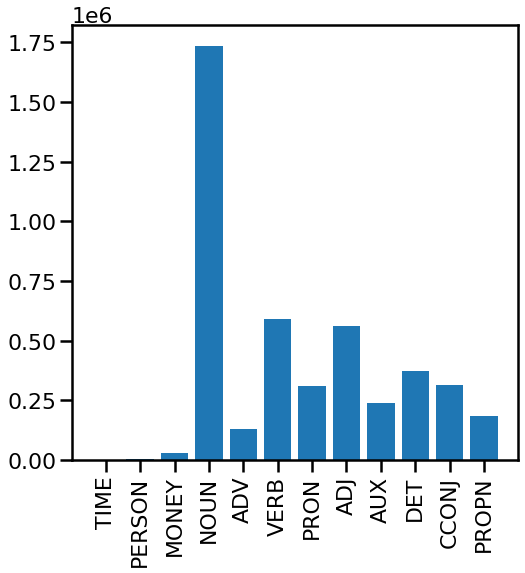

In [66]:
names, counts = zip(*sum_ent.items())
fig, ax = plt.subplots(figsize=(8,8))
plt.xticks(rotation=90)
plt.bar(names, counts)

#### Unsurprisingly, **MONEY** was mentioned the most among the three entities: **TIME**, **PERSOM**, and **MONEY**, since the dataset was derived from the annual financial reports. Nevertheless, **NOUN**s appeared the most among all the other entities. 

In [67]:
# Vectorize entitiy and POS counts
vectorizer = DictVectorizer(sparse=False)
X_trans = vectorizer.fit_transform(text_data)
print("Shape of the transformed matrix: ", X_trans.shape)

Shape of the transformed matrix:  (304, 12)


In [68]:
# Scale
# Standard-scale your feature matrix
X_trans = StandardScaler().fit_transform(X_trans)
print("Shape of the scaled matrix: ", X_trans.shape)

Shape of the scaled matrix:  (304, 12)


In [69]:
%time
# trying diff max_features
classifiers = {
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression(),
    'Decision tree':DecisionTreeClassifier(),
    'Random forest':RandomForestClassifier(),
    'LinearSVC':LinearSVC(max_iter=10000),
    'SVC':SVC(),
    'RandomForest':RandomForestClassifier(max_features=2)
}

scores = {} 
for classifier in classifiers:
    scores[classifier] = cross_validate( 
        classifiers[classifier], 
        X_trans, # feature matrix
        y_binary, # gold labels
        cv=10, 
        scoring=['accuracy', 'recall', 'f1', 'f1_macro', 'f1_micro'] 
    )

compare_scores(scores)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


,fit_time,score_time,test_accuracy,test_recall,test_f1,test_f1_macro,test_f1_micro
kNN,0.001603,0.004803,0.486344,0.333333,0.331239,0.452850,0.486344
Logit,0.008806,0.002844,0.615591,0.250000,0.330739,0.528349,0.615591
Decision tree,0.001878,0.002614,0.483118,0.391667,0.363269,0.459892,0.483118
Random forest,0.119538,0.010772,0.564839,0.283333,0.327659,0.500152,0.564839
LinearSVC,0.025985,0.002560,0.618602,0.300000,0.368619,0.545318,0.618602
SVC,0.004372,0.004332,0.588817,0.141667,0.207951,0.464369,0.588817
RandomForest,0.108408,0.010502,0.538495,0.275000,0.311895,0.479832,0.538495


#### Looks like Linear SVC classifier worked best in terms of entities and POS tag feature matrix for both accuray and F1 scores, however, the latter was lower than the baseline F1. 

### 4. Build Topic Modeling feature matrix

In [70]:
# Vectorize
vectorizer = CountVectorizer( # Token counts, not normalized (sklearn normalizes later)
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    stop_words='english', # uncomment to remove fixed stops from input
    lowercase = True,
    min_df = 0.001, # Remember that we've chunked by paragraph
    max_df = 0.25,    # Ditto
    token_pattern=r'(?u)\b[A-Za-z]+\b'
)

X_topic = vectorizer.fit_transform(df.risk)
print("Feature matrix shape:", X_topic.shape)
print("Total vectorized words in the corpus:", X_topic.sum())
print("Average vectorized paragraph length:", int(X_topic.sum()/X_topic.shape[0]), "tokens")

Feature matrix shape: (304, 19948)
Total vectorized words in the corpus: 477270
Average vectorized paragraph length: 1569 tokens


In [71]:
%%time
lda = LatentDirichletAllocation(
    n_components=20, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=10,     # Might want more in production work
    evaluate_every=0 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X_topic)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
CPU times: user 946 ms, sys: 862 ms, total: 1.81 s
Wall time: 5.24 s


LatentDirichletAllocation(evaluate_every=0, n_components=20, n_jobs=-1,
                          verbose=1)

In [72]:
# Print top words per topic

def print_top_words(model, feature_names, n_top_words, hide_stops=False):
    if hide_stops:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx: >2}: "
        top_words_idx = topic.argsort()
        if not hide_stops:
            top_words = [feature_names[i]
            for i in top_words_idx[:-n_top_words - 1:-1]]
        else:
            top_words = []
            i = 1
            while len(top_words) < n_top_words:
                if feature_names[top_words_idx[-i]] not in ENGLISH_STOP_WORDS:
                    top_words.append(feature_names[top_words_idx[-i]])
                i += 1
        message += " ".join(top_words)    
        print(message)
    print()

In [73]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, hide_stops=False)

Topic  0: games hosts guests analog asu game exhibit semiconductor hittite interactive
Topic  1: splunk developers subscribers machine apps engagement facebook search dvd windows
Topic  2: semiconductor thousands tencor kla vesting invisalign ending unrealized lti inspection
Topic  3: exelon peco comed registrants nuclear bge electric electricity ferc wholesale
Topic  4: sanofi aventis collaboration simulation ansys vegf arcalyst eye bayer antibody
Topic  5: gilead registrant sciences dated clinical exhibit therapeutics thousands cv ipr
Topic  6: hotel iac search complaint defendants domain hotels city priceline google
Topic  7: csx honeywell pension millions exhibit asbestos rail csxt corporationpart narco
Topic  8: paypal merchants eu subscription mr ebay laundering cards hosted subscriptions
Topic  9: wireless spectrum fcc lte handsets roaming broadband warrants deutsche telekom
Topic 10: clinical fda glucose trials trial patients diabetes commercialization seven payors
Topic 11: id

In [74]:
# Create a doc-topic matrix
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    doc_topic_matrix = lda.transform(X_topic)
print("Doc-topic matrix shape:", doc_topic_matrix.shape)

Doc-topic matrix shape: (304, 20)


In [75]:
classifiers = {
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression(),
    'Decision tree':DecisionTreeClassifier(),
    'Random forest':RandomForestClassifier(),
    'LinearSVC':LinearSVC(max_iter=10000),
    'SVC':SVC(),
    'RandomForest':RandomForestClassifier(max_features=2)
}

scores={}

for classifier in classifiers:
    scores[classifier] = cross_validate(classifiers[classifier], doc_topic_matrix, y_binary, cv=10, scoring=['accuracy', 'recall', 'f1', 'f1_macro', 'f1_micro'])

compare_scores(scores)

,fit_time,score_time,test_accuracy,test_recall,test_f1,test_f1_macro,test_f1_micro
kNN,0.000621,0.005472,0.427204,0.325000,0.285525,0.388732,0.427204
Logit,0.004684,0.002824,0.548280,0.241667,0.260551,0.457255,0.548280
Decision tree,0.003176,0.002612,0.466022,0.316667,0.323942,0.436450,0.466022
Random forest,0.125094,0.011017,0.462581,0.275000,0.269955,0.416456,0.462581
LinearSVC,0.001302,0.002510,0.541935,0.450000,0.428637,0.514697,0.541935
SVC,0.002913,0.003167,0.508495,0.283333,0.293311,0.449123,0.508495
RandomForest,0.112279,0.010983,0.489462,0.283333,0.288801,0.440012,0.489462


#### All the classifiers outperformed the baseline accuracy scores using the topic modeling feature matrix. As a reminder, `y_binary` (Baseline accuracy: 0.395, Baseline F1: 0.566). I will try to optimize the parameters of random forest classifier below. 

In [76]:
# trying diff max_features
RFfeatures = {
    'feature_None':RandomForestClassifier(max_features=None),
    'feature_100':RandomForestClassifier(max_features=10),
    'feature_5':RandomForestClassifier(max_features=5),
    'feature_2':RandomForestClassifier(max_features=2),
    'est_og':RandomForestClassifier()
}

RFscores1 = {} 
for classifier in RFfeatures:
    RFscores1[classifier] = cross_validate( 
        RFfeatures[classifier], 
        doc_topic_matrix, # feature matrix
        y_binary, # gold labels
        cv=10, 
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] 
    )

compare_scores(RFscores1)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
feature_None,0.247595,0.012171,0.429355,0.264742,0.300000,0.268775,0.389092,0.429355
feature_100,0.168169,0.011618,0.439892,0.274915,0.275000,0.268231,0.401282,0.439892
feature_5,0.130956,0.011587,0.482258,0.307416,0.291667,0.290754,0.436857,0.482258
feature_2,0.108628,0.011417,0.482903,0.290216,0.283333,0.283508,0.435281,0.482903
est_og,0.124809,0.011412,0.472903,0.293452,0.283333,0.277265,0.424771,0.472903


#### It seems random forest with the default parameter `max_features=sqrt(n_features)` has the highest accuracy score, and the one with `max_features=None` had the best F1 score, which was still lower than the baseline F1. 

#### In conclusion, the random forest classier with the token-based feature matrix outperformed other feature matricies in building a classifier to categorize the below-average-stock-price and above-average-stock-price in the Q3 analysis. 

# Part 4: Results and Discussion

**Q1: What are the tones or sentiments used to describe the risks of companies? Are they related to the stock prices?**

**Sentiment Analysis**

I started with sentiment analysis for all the risk factors across the companies, and grouped them by below-average-stock-price vs. above-average-stock-price. To summarize my findings, 

* (1) Across all the emotions, it seemed those publicly traded companies tended to use **positive** tones in their writings of the Risk Factors section no matter what their stock performances were, compared to any other emotions. 

* (2) The emotion **surprise** is the least mentioned in the Risk Factors section. It seemed those companies used caution when publishing their 10-K annual reports, trying not to deliver any surprising messages to scare them away. 

* (3) Both the **positive** and **trust** emotions showed statistically significant between below-average and above-average stock prices. Namely, when companies performed better than the average stock prices, they tended to be more optimistic about their risks and would assure their investors about their competence. 

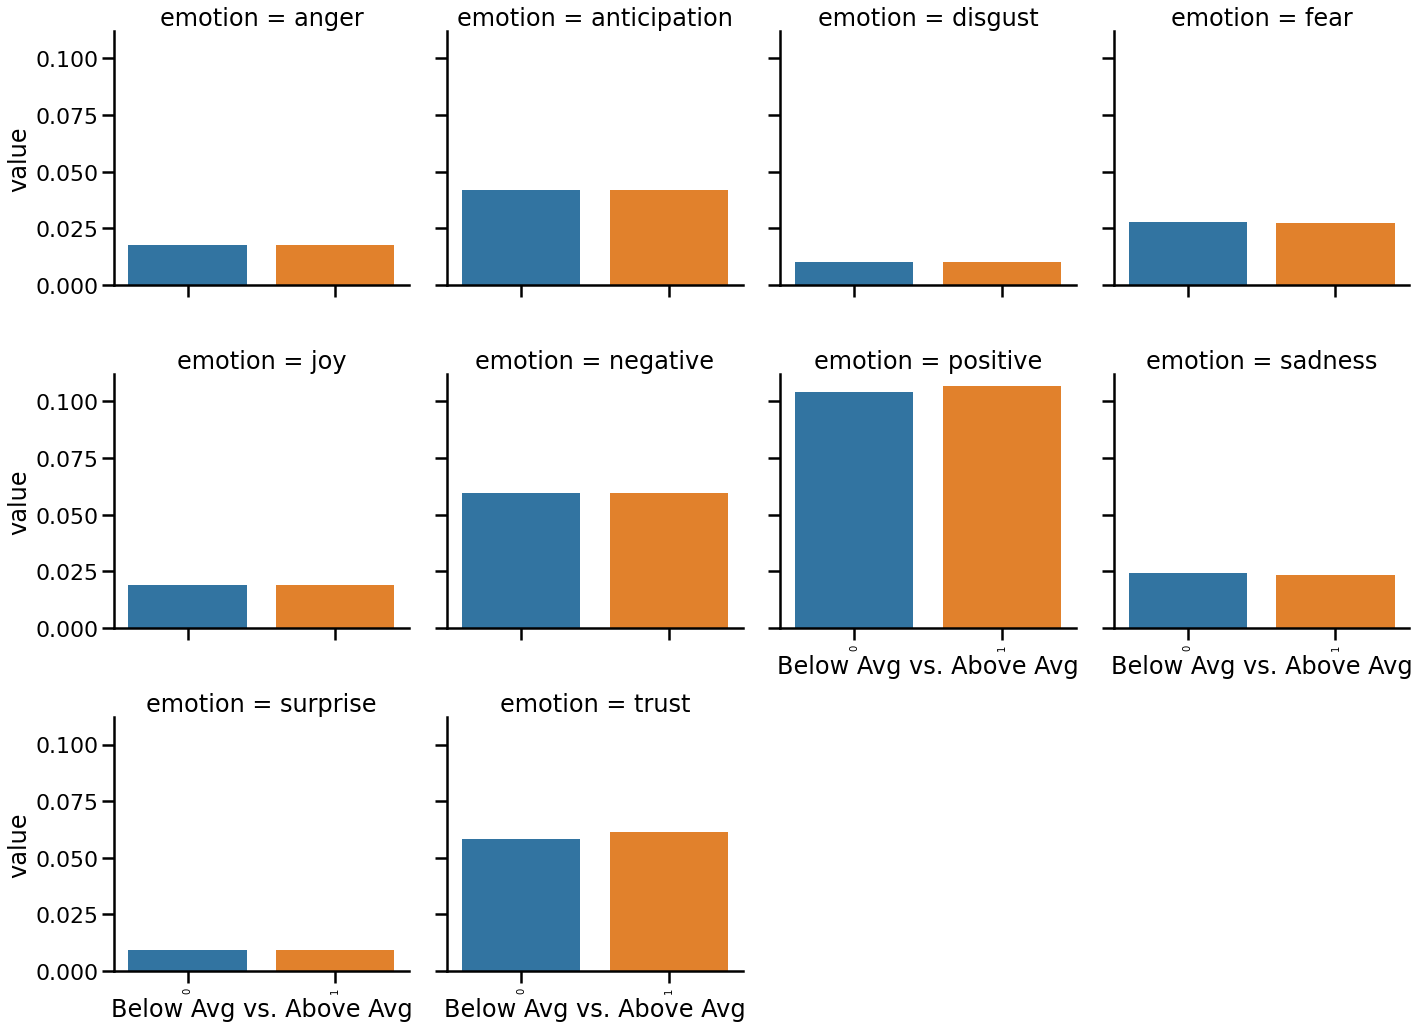

In [77]:
visualize_emotion_scores(sent_dict, 4, 'Below Avg vs. Above Avg')

Next, I visualized the sentiment analysis by sector. 

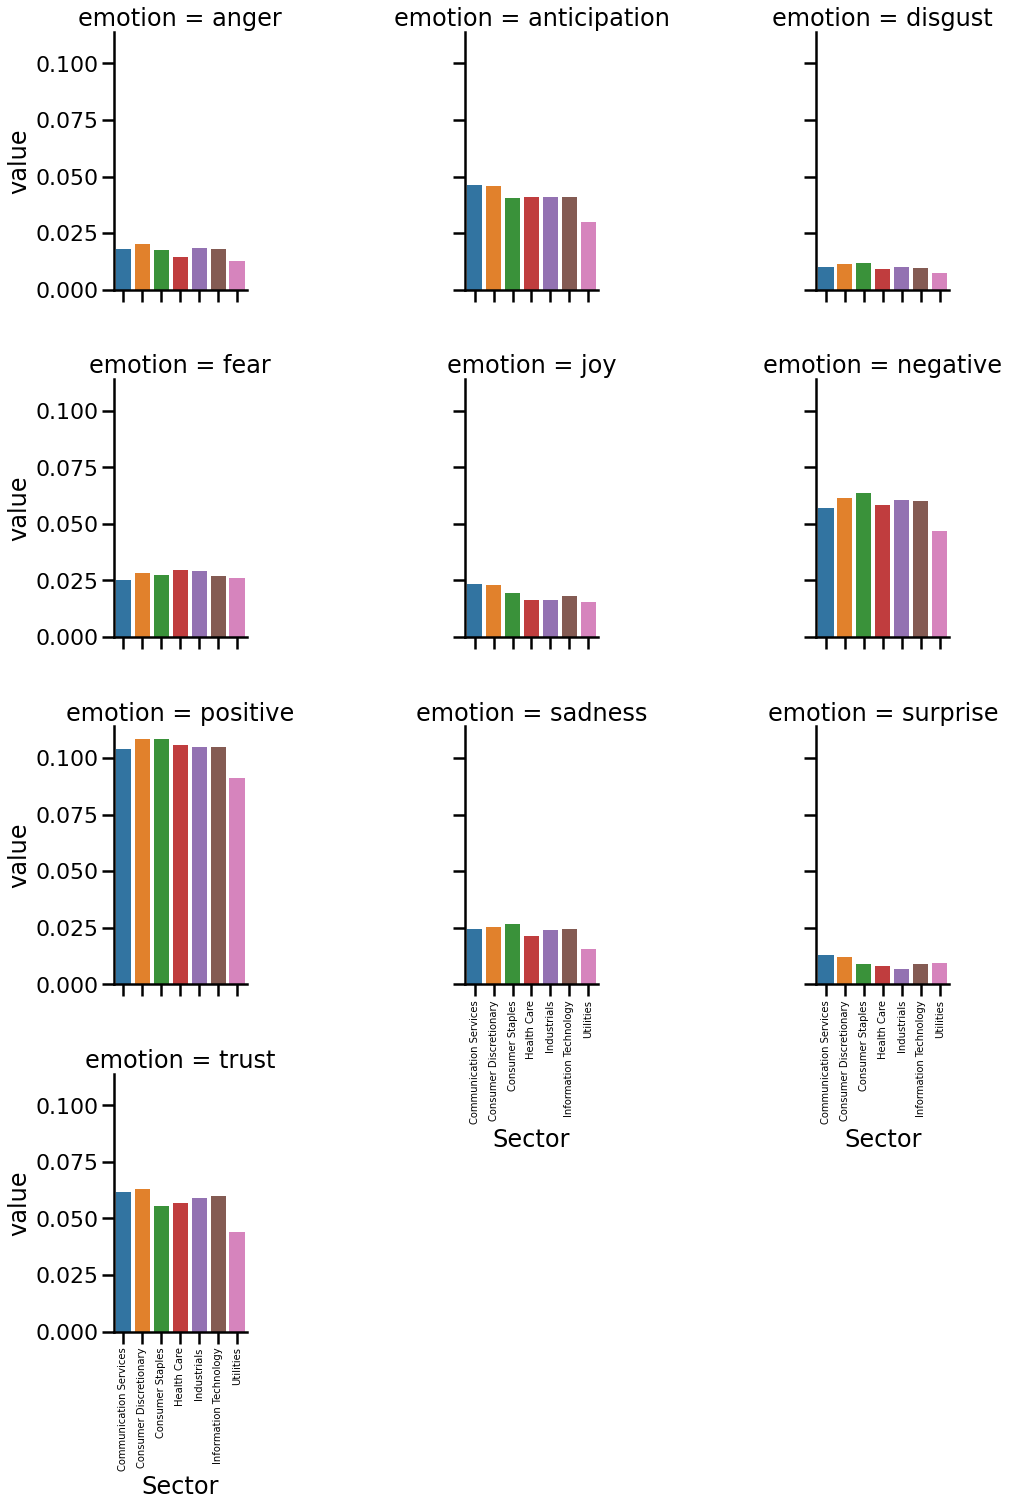

In [78]:
visualize_emotion_scores(sent_sec_dict, 3, 'Sector')

* (1) The sector **Utilities** appeared to have the lowest mean sentiment scores among any other sectors, except for the *surprise* emotion. In our dataset, there is only one company made up this category: 'Exelon Corporation'. So, the sentiment result might be underrepresented. 

* (2) The **Consumer Discretionary** sector would like to deliver *anticipation*, *positivity* and *trust* emotions to their audience in their Risk Factors sections. Companies in this sector included Tesla, Airbnb, Amazon, Lululemon, Dollar Tree, and so on. In common sense, most of them were also considered fast-growing companies in the past 15 years. 

* (3) The **Consumer Staples** sector showed slightly more worries regarding the risks in their 10-K reports and ranked the highest in *sadness* and *negative* emotion categories. There are four companies in this category in our dataset: Walgreens, PepsiCo, Mondelez International, and The Kraft Heinz Company. This industry was regarded as steady, less risky and volatile, which might be the reason why companies might not pay attention to the *sadness* or *negativeness* in their statements. 

**KMeans Clustering**

Because of the sentiment analysis on sector, I decided to use n = number_of_sector clusters to see if there was a differentiation among sectors. Since the features haven’t been selected yet, I used the `pull_samples` function to see if I can evaluate the samples pulled from the clusters and manually analyze any similarities and differences. From the *k-Means (predicted) labels* graph below, we can see that most of the data fall into the *label 1* cluster. 

Label vector shape:  (304,)
Using KMeans clustering with n=7 clusters; we are assuming that the clusters are based on sectors.


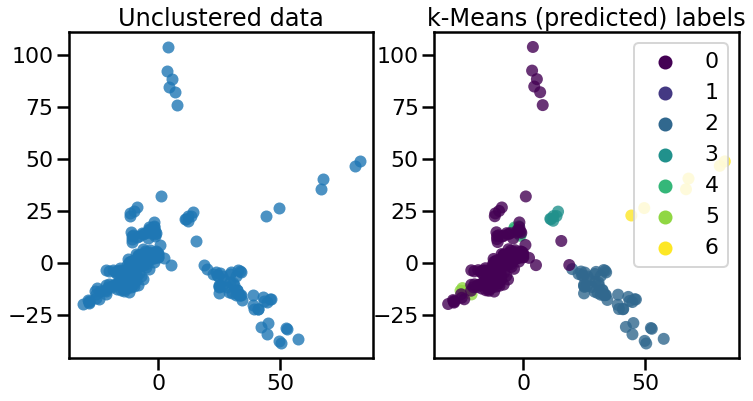

In [79]:
y_kmeans = KMeans(n_clusters=7).fit_predict(X) # this output is the cluster labels

# Print label vector shape
print('Label vector shape: ', y_kmeans.shape)

print("Using KMeans clustering with n=7 clusters; we are assuming that the clusters are based on sectors.")

# Plot results
plot_compare(X, y_kmeans, 'k-Means (predicted) labels', reduce=True, alpha=0.8)

After pulling the samples of each cluster, we identified that some of the clusters consisted of only one or two companies. This indicated that those companies were distinct in their writings of their risk factors, compared to their counterparts. For instance, IDEXX Laboratories (Health Care), Lululemon Athletica (Consumer Discretionary), Copart (Industrials), Exelon Corporation (Utilities), and CSX Corporation (Industrials) had their own clusters, while other companies made up the rest of the cluster. Additionally, cluster 6 clearly had much shorter word count than the others. Last but not least, the variability of cluster 1 showed us that sector might not be a defining feature for the clusters. In future studies, the company names may need to be removed for more accurate clustering analysis. 

**Q2. Can we build a classifier to categorize the IT sector and non-IT sector by their Risk Factors? If so, what features are most important?**

Looking at the descriptive statistics by sector, we learned that over 50% of the companies in our data set came from the Information Technology (IT) sector. Therefore, it would be interesting to see if they had distinguishable risk factors in their 10-K reports compared to the non-IT industries. 

This is our baseline accuracy for IT sector: 

In [80]:
baseline_accuracy_it

0.555921052631579

After selecting the 20 most important features of our feature matrix, I cross-validated the various classifiers with the feature matrix, such as logistic regression classifier, random forest classifier, and decision tree classifier. All of them seemed to have promising accuracy results over 80%. In particular, with the random forest classifier (`max_feature=2`), the accuracy score reached up to 90%! 

The top 20 important features showed us the most identifiable for the IT sectors, such as *computing*, *engineering*, *oci* (Oracle Cloud Infrastructure), *semiconductor*, *software*, *technology*, and so on. We could conclude that the random forest classfier successfully classify the IT vs. Non-IT sectors in the risk corpus. 

**Q3: Can we build a classifier to categorize the below-average-stock-price and above-average-stock-price by their Risk Factors from 10-K reports? What are the most important features to distinguish them? Can we improve the accuracy of our classifiers?**

For the token-based feature matrix, with the 50 most important features, the mean cross-validated accuracy score of the logistic regression classifier was 0.6, which was much higher than the baseline of *y_binary* (0.3947). 

In [81]:
baseline_accuracy

0.39473684210526316

Then I used *feature engineering* and tried a variety of classifiers with different parameters. It seems random forest with the default parameter `max_features=sqrt(n_features)` has the highest accuracy score, and the one with `max_features=None` had the best F1 score, which was still lower than the baseline F1. By evaluating other feature matrices, e.g. word-embedding feature matrix, entities and POS tags feature matrix, and the topic modeling feature matrix, I found some interesting results as well. For example, as the following figure showed, **MONEY** was mentioned the most among the three entities: **TIME**, **PERSON**, and **MONEY**, since the dataset was derived from the annual financial reports. Nevertheless, **NOUN**s appeared the most among all the other entities. 

<BarContainer object of 12 artists>

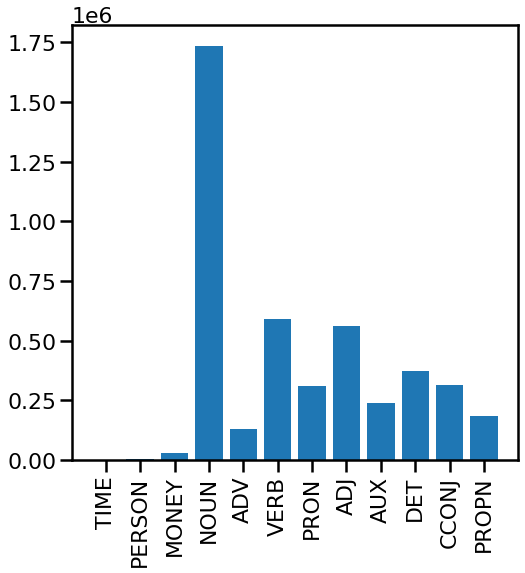

In [82]:
fig, ax = plt.subplots(figsize=(8,8))
plt.xticks(rotation=90)
plt.bar(names, counts)

In [83]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, hide_stops=False)

Topic  0: games hosts guests analog asu game exhibit semiconductor hittite interactive
Topic  1: splunk developers subscribers machine apps engagement facebook search dvd windows
Topic  2: semiconductor thousands tencor kla vesting invisalign ending unrealized lti inspection
Topic  3: exelon peco comed registrants nuclear bge electric electricity ferc wholesale
Topic  4: sanofi aventis collaboration simulation ansys vegf arcalyst eye bayer antibody
Topic  5: gilead registrant sciences dated clinical exhibit therapeutics thousands cv ipr
Topic  6: hotel iac search complaint defendants domain hotels city priceline google
Topic  7: csx honeywell pension millions exhibit asbestos rail csxt corporationpart narco
Topic  8: paypal merchants eu subscription mr ebay laundering cards hosted subscriptions
Topic  9: wireless spectrum fcc lte handsets roaming broadband warrants deutsche telekom
Topic 10: clinical fda glucose trials trial patients diabetes commercialization seven payors
Topic 11: id

From the topic modeling, we could also find the top topics mentioned in the risk factors across all the 304 reports. *FDA*, *drug*, and *clinical* were mentioned quite often (topic 10, 16, 18), which might have something to do with the development of new drugs. The word *semiconductor* was mentioned frequently across topics 0, 2, 12, and 15, which might reflect the semiconductor shortage around the world in the recent years. Companies were also concerned about up-to-date their products or services are, which we could tell from topic 5, 12, 15, and 17 where they kept mentioning *dated* in their risk factors. 

# Part 5: Conclusion

**Q1: What are the tones or sentiments used to describe the risks of companies? Are they related to the stock prices?**

From the sentiment analysis and the results of t-test showed that there was a significant difference in both the **positive** and **trust** emotions between below-average and above-average stock prices. To be more concrete, when companies performed better than the average stock prices, they tended to be more optimistic about their risks and would be more likely to assure their investors about their competence in the market. 

**Q2. Can we build a classifier to categorize the IT sector and non-IT sector by their Risk Factors? If so, what features are most important?** 

All the classifiers were able to surpass the baseline accuracy benchmark of `0.5559` even without optimization of parameters. The random forest classifier (`max_feature` = 2) based on the top 20 features from the risk corpus was successfully reached to a high accuracy score of `0.9`. The top 20 important features showed us the most identifiable for the IT sectors, such as *computing*, *engineering*, *oci* (Oracle Cloud Infrastructure), *semiconductor*, *software*, *technology*, and so on. The random forest classfier successfully classify the IT vs. Non-IT sectors in the risk corpus. 

**Q3: Can we build a classifier to categorize the below-average-stock-price and above-average-stock-price by their Risk Factors from 10-K reports? What are the most important features to distinguish them? Can we improve the accuracy of our classifiers?** 

All the classifiers were able to surpass the baseline accuracy benchmark of `0.3947`. In particular, it seems random forest with the default parameter `max_features=sqrt(n_features)` has the highest accuracy score, and the one with `max_features=None` had the best F1 score, which was still lower than the baseline F1. By evaluating the entities and topic modeling feature matrices, we could find a lot of interesting aspects of the risk corpus, which was discussed in *Part 4: Results and Discussion*. 

# Part 6: Limitation

* The stock prices collected for the companies were based on the December of the given fiscal year, yet some of the companies have set their fiscal year to be September or other months. We should do more research on which month or metric to represent a company’s performance in a given fiscal year in the stock market.  

* The 10-K reports pulled from SEC website for the companies were not continuous, which means for company A, its 10-K reports from 2015 and 2017 might be pulled, while other fiscal years’ reports were missing in the dataset. In the future studies, a more complete list of 10-K reports should be found and pulled. 

# Part 7: Reflection

Like many data science projects, the web scraping and data cleaning became the most challenging part of this project. As a rookie in web scraping, I spent over 20 hours learning web scraping and actually obtaining the data. Since my goal was to use the 10-K reports to classify the stock price, I needed to scrap both sites: the SEC website and Yahoo Finance. It took a long trial and error process, especially with the 10-K reports scraping. I used *Inspect* feature in Chrome to find the HTML tags that contained the text I wanted. One big issue I had was the data was dynamically generated by JavaScript, after researching online, I used selenium
*webdriver.Firefox()* to start local sessions of Firefox automatically, and then parse the text. When scraping Yahoo Finance, I found the most challenging part was to find the key-value pair from a very long JSON object that has the historical stock prices for a company. To solve it, I used VS Code JSON formatter and was able to find the historical data. 

# Part 8: References

* INFO 6/3350 Text Mining History and Literature (2022SP) lecture code

* https://github.com/areed1192/sigma_coding_youtube/tree/master/python/python-finance/sec-web-scraping

* https://www.youtube.com/watch?v=fw4gK-leExw&ab_channel=IzzyAnalytics

* https://en.wikipedia.org/wiki/Nasdaq-100

* https://stackoverflow.com/questions/48687857/python-json-list-to-pandas-dataframe

* https://www.sec.gov/

* https://finance.yahoo.com/

# Part 9: Responsibility Statement

I completed this project on my own. 